


### Return forecasting regressions:

- ###  1.1. Using CRSP, get monthly market returns ex and cum dividends, as well as the monthly t-bill rate, from 1963 through 2019. 
Create the market dividend yield by summing the dividends over the last 12 months and divide by current price (you can do this using information extracted using the ex- and cum-dividend returns). Construct excess returns by subtracting the log of the 1-month gross t-bill rate from the 1-month gross cum-dividends returns. Note: to get to gross returns you may have to add 1 to the original data series. From the St. Louis Fed data page (FRED; https://fred.stlouisfed.org/), get monthly data on the term and default spreads for the same sample. For the former, use the "10- Year Treasury Constant Maturity Minus Federal Funds Rate," for the latter subtract "Moodyís Seasoned Aaa Corporate Bond Minus Federal Funds Rate" from "Moodyís Seasoned Baa Corporate Bond Minus Federal Funds Rate."


In [1]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

# Importing libraries
import os
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import scipy.stats as ss
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats, linalg
import yfinance as yf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from time import time
from datetime import timedelta

aaa_data = r"C:\Users\user\Documents\default_aaa_spread.csv"
file_CRSP_data = r"C:\Users\user\Documents\CRSP_data.csv"
file_baa_hy = r"C:\Users\user\Documents\term_spread.csv"
file_rf_rate = r"C:\Users\user\Documents\rf_rate.csv"
file_10yff = r"C:\Users\user\Documents\10yff.csv"

#Set crsp dataframe as the main data frame
df = pd.read_csv(file_CRSP_data, parse_dates=['DATE'])
df = df.rename(columns={"DATE": "date", "vwretd": "TotalReturn", "vwretx": "Price Return"})
#import peripheral dataframes
df_aaa = pd.read_csv(aaa_data)
df_baa = pd.read_csv(file_baa_hy)
df_rf = pd.read_csv(file_rf_rate)
df_10yrff = pd.read_csv(file_10yff)


In [2]:
# get everything into one dataframe.  since we match index lengths lets pull dfseries so 
# we only have to parse one datetime.
df=pd.concat([df["date"],df['TotalReturn'],df['Price Return'], df_aaa['AAAFFM'], df_baa['BAAFFM'], df_rf['TB3M'] ], axis = 1)
#unsure why I can't get 10yr concat but lets just merge and drop its DATE column
df = df.merge(df_10yrff, left_index=True, right_index=True )
df = df.drop(['DATE'], axis = 1)
df.set_index(['date'])
#adjust data
df['TB3M'] = df.apply(lambda x: x['TB3M']/100, axis = 1 )
df['AAAFFM'] = df.apply(lambda x: x['AAAFFM']/100, axis = 1)
df['BAAFFM'] = df.apply(lambda x: x['BAAFFM']/100, axis = 1)
# ---------------------------------------------------------------------------------------------------



#Lets get dividend information into the data frame. 
df['CumProd Price Return'] =  (1 + df['Price Return']).cumprod()
df['Dividend Rtr'] = df.apply(lambda x: (x["TotalReturn"] - x['Price Return']), axis = 1)
df['Dividend'] = df['Dividend Rtr']*df['CumProd Price Return'].shift(1)
df['Div/Price'] = df['Dividend'].rolling(12).sum()/df['CumProd Price Return']
df = df.dropna()


# Create Excess Returns
df['ExcessReturns'] = df.apply(lambda x:(np.log(x['TotalReturn']+1)- np.log(x['TB3M'] +1)), axis = 1)
# Create Term and credit spreads. (10yr - rf = tspread?)
df['Term Spread'] = df.apply(lambda x: x['T10YFF'] - x['TB3M'], axis = 1)
df['Credit Spread'] = df.apply(lambda x: x['AAAFFM'] - x['BAAFFM'], axis = 1)


# 2.1 Plot your data.

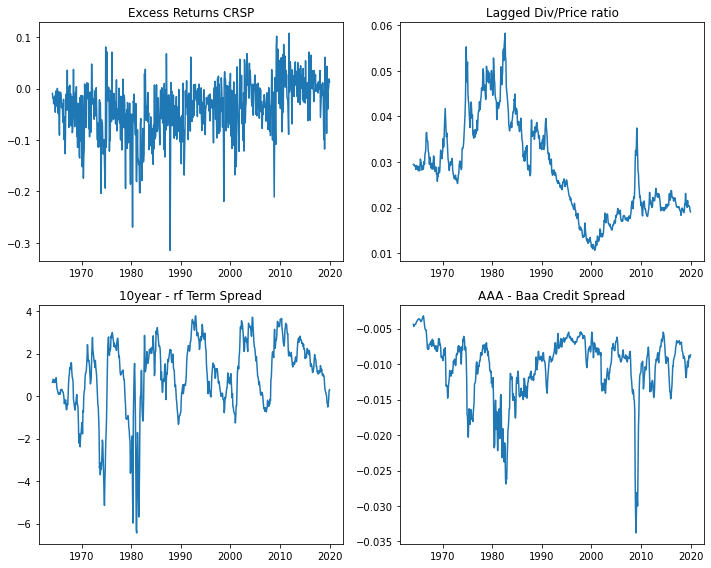

In [3]:
# --------------------------------Question 2 Plot this -------------------------------------------
df = df.set_index('date')

fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.plot(df['ExcessReturns'])
ax1.set_title('Excess Returns CRSP')
ax2.plot(df['Div/Price'])
ax2.set_title("Lagged Div/Price ratio")
ax3.plot(df['Term Spread'])
ax3.set_title("10year - rf Term Spread")
ax4.plot(df['Credit Spread'])
ax4.set_title("AAA - Baa Credit Spread")
plt.tight_layout()
plt.show()


### Using your three predictive variables (the lagged dividend yield, term spread, and default spread), forecast excess equity returns at the 1-month, 3-month, 12-month, 24-month, and 60-month horizons. 
Report your results from each of these regressions
(regression coe¢ cients, standard errors, and R2s). The underlying data is monthly, so
make sure to explain your choice of standard errors.

In [4]:
# one month.  
y=df['ExcessReturns']
X = df[['Term Spread', "Credit Spread", "Div/Price"]]
X = sm.add_constant(X)
multi_reg = sm.OLS(y, X)
one_month_est = multi_reg.fit()
print(one_month_est.summary())

print(f"Coefficients:\n{one_month_est.params}\n.")
print(f"OLS Standard errors:\n{one_month_est.bse}\n")
print(f"White Standard errors:\n{one_month_est.HC0_se}")
print(f"Predicted values:\n{one_month_est.predict()[0]}")

                            OLS Regression Results                            
Dep. Variable:          ExcessReturns   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     87.02
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           1.54e-47
Time:                        18:25:59   Log-Likelihood:                 1115.7
No. Observations:                 672   AIC:                            -2223.
Df Residuals:                     668   BIC:                            -2205.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.006      0.211

In [5]:
#3 month
df_3month = df.resample("3M").sum()
y=df_3month['ExcessReturns']
X = df_3month[['Term Spread', "Credit Spread", "Div/Price"]]
X = sm.add_constant(X)
multi_reg = sm.OLS(y, X)
three_month_est = multi_reg.fit()
print(three_month_est.summary())
print(f"Coefficients:\n{three_month_est.params}\n.")
print(f"OLS Standard errors:\n{three_month_est.bse}\n")
print(f"White Standard errors:\n{three_month_est.HC0_se}")
print(f"Predicted values:\n{three_month_est.predict()[0]}")


                            OLS Regression Results                            
Dep. Variable:          ExcessReturns   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     68.07
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           3.27e-31
Time:                        18:26:31   Log-Likelihood:                 236.21
No. Observations:                 225   AIC:                            -464.4
Df Residuals:                     221   BIC:                            -450.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.019     -0.308

In [6]:
# 12 month
df_12month = df.resample("12M").sum()
y = df_12month['ExcessReturns']
X = df_12month[['Term Spread', "Credit Spread", "Div/Price"]]
X = sm.add_constant(X)
multi_reg = sm.OLS(y, X)
twelve_month_est = multi_reg.fit()
print(twelve_month_est.summary())
print(f"Coefficients:\n{twelve_month_est.params}\n.")
print(f"OLS Standard errors:\n{twelve_month_est.bse}\n")
print(f"White Standard errors:\n{twelve_month_est.HC0_se}")
print(f"Predicted values:\n{twelve_month_est.predict()[0]}")

                            OLS Regression Results                            
Dep. Variable:          ExcessReturns   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     34.63
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           1.57e-12
Time:                        18:26:33   Log-Likelihood:                 4.1759
No. Observations:                  57   AIC:                           -0.3519
Df Residuals:                      53   BIC:                             7.820
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0131      0.100      0.131

In [7]:
#---------------------------------------------------------------------------
# 24 month
df_24month = df.resample("24M").sum()
y = df_24month['ExcessReturns']
X = df_24month[['Term Spread', "Credit Spread", "Div/Price"]]
X = sm.add_constant(X)
multi_reg = sm.OLS(y, X)
est_24 = multi_reg.fit()
print(est_24.summary())
print(f"Coefficients:\n{est_24.params}\n.")
print(f"OLS Standard errors:\n{est_24.bse}\n")
print(f"White Standard errors:\n{est_24.HC0_se}")
print(f"Predicted values:\n{est_24.predict()[0]}")

                            OLS Regression Results                            
Dep. Variable:          ExcessReturns   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     24.14
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           1.48e-07
Time:                        18:26:34   Log-Likelihood:                -10.803
No. Observations:                  29   AIC:                             29.61
Df Residuals:                      25   BIC:                             35.08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0294      0.219      0.134

In [8]:
#----------------------------------------------------------------------------
df_60month = df.resample("60M").sum()
y = df_60month['ExcessReturns']
X = df_60month[['Term Spread', "Credit Spread", "Div/Price"]]
X = sm.add_constant(X)
multi_reg =sm.OLS(y, X)
est_60 = multi_reg.fit()
print(est_60.summary())
print(f"Coefficients:\n{est_24.params}\n.")
print(f"OLS Standard errors:\n{est_24.bse}\n")
print(f"White Standard errors:\n{est_24.HC0_se}")
print(f"Predicted values:\n{est_24.predict()[0]}")

                            OLS Regression Results                            
Dep. Variable:          ExcessReturns   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     13.18
Date:                Tue, 22 Feb 2022   Prob (F-statistic):            0.00121
Time:                        18:26:37   Log-Likelihood:                -14.328
No. Observations:                  13   AIC:                             36.66
Df Residuals:                       9   BIC:                             38.92
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0110      0.586      0.019

C:\Users\user\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "




### Plot the estimated expected 12-month excess return and forecast the regression out of sample. 

What type of periods are associated with high expected returns and what type of periods are associated with low expected returns. Does the patterns make sense to you? What are the economic stories you would tell to explain these patterns?

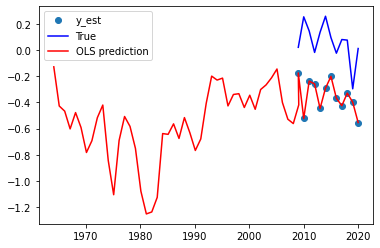

In [9]:


#------------------Question 4-----------------------------------
train_end = datetime(2008, 10 ,31)
test_end = datetime(2019,12,31)
train_data = df[:train_end]
test_data = df[train_end + timedelta(days = 30): test_end]

train_12 = train_data.resample("12M").sum()
test_12 = test_data.resample("12M").sum()

#  Training Set prediction
y = train_12['ExcessReturns']
X = train_12[['Term Spread', "Credit Spread", "Div/Price"]]
X = sm.add_constant(X)
multi_reg = sm.OLS(y, X)
train_est = multi_reg.fit()
# print(train_est.summary())
ypred = train_est.predict(X)
# print(ypred)

#---test data-----
y_true = test_12["ExcessReturns"]
X_test = test_12[['Term Spread', "Credit Spread", "Div/Price"]]
X_test = sm.add_constant(X_test)
y_test_est = train_est.predict(X_test) # out of sample test. 


# Plot
fig, ax = plt.subplots()
ax.plot(test_12.index, y_test_est, "o", label="y_est")
ax.plot(test_12.index, y_true, "b-", label="True")
ax.plot(np.hstack((train_12.index, test_12.index)), np.hstack((ypred, y_test_est)), "r", label="OLS prediction")
ax.legend(loc = 'best')



### In the data, low price and narrowing spreads are associated with market outperformance.   Past cross-sectional variables may not be leading indcators of future events given the fact that the lagged predictor values had lower valuation characteristics. I highly suspect there was a regime change within the dividend to price predictor coefficient. 

--------------

### Why do you think using, say, an AR(1)-type setting could be useful instead of simply regressing returns at different horizons on lagged predictive variables as we have done in this problem?




### I believe an AR(1)/AR(P) model could provide more predicitve power than cross-sectional lagged factors because those lagged factors would not be adjusting to new information as readily or as quickly as an AR(p) forecast could.  

-----



### Using the 1-month forecast, calculate the Sharpe ratio of a strategy that uses portfolio loading $\omega_{t} - \mu_{t}$ on the market, where $\mu_{t} = \mathbb{E_{t}}(r_{t+1})$  from your forecasting regression.  




$$ \text{Sharpe Ratio} = \frac{\text{Mean Portfolio Return} - \text{Risk free rate}} {\text{Standard deviation of portfolio return}}$$


In [43]:

# -----------------------------1 month-----------------------------------------
train_end = datetime(2008, 10 ,31)
test_end = datetime(2019,12,31)
train_data = df[:train_end]
test_data = df[train_end + timedelta(days = 30): test_end]

# one month.  
y=train_data['ExcessReturns']
X = train_data[['Term Spread', "Credit Spread", "Div/Price"]]
X = sm.add_constant(X)
multi_reg = sm.OLS(y, X)
one_month_est = multi_reg.fit()
y_pred_1month = one_month_est.predict(X)

# test one month out of sample 
y_true = test_data['ExcessReturns']
X_test = test_data[['Term Spread', "Credit Spread", "Div/Price"]]
X_test = sm.add_constant(X_test) # testing out of sample

#I'm literally just taking the predictions of the cross section returns and computing that as a strategy fot wtRt+1
y_test_est = one_month_est.predict(X_test)

portfolio_est_vol = np.std(y_test_est)

sharpe_1month_prediction = y_test_est/portfolio_est_vol
#calculate the y_true sharpe of a buy and hold


#Buy & Hold  Taking true values of holding the portfolio

b_h_vol = np.std(y_true)
b_h_sharpe = y_true/b_h_vol
 



In [44]:
# Take latest Buy and hold sharpe
print(f"The most recent B&H sharpe is {sharpe_1month_prediction.iloc[::-1][0]}.")
print(f"The most recent B&H sharpe is {b_h_sharpe.iloc[::-1][0]}.")

The most recent B&H sharpe is -3.933190756593925.
The most recent B&H sharpe is 0.3158806124512862.


# Question 2:  M/B ratios and the present value formula:

### In class, we derived a log-linear present value formula using the Campbell-Shiller return decomposition: 

## $$r_{t+1} = \kappa_{0} + \rho * pd_{t+1} - pd_{t} + \Delta d_{t+1}$$  

### While this decomposition is very accurate, it does require a stationary pd-ratio and positive dividends. Many firms do not pay dividends, which means this formula is not always useful at the firm level.



### However, Ohlson (Contemporary Accounting Research, 1995) and Vuolteenaho (Journal of Finance, 2002) derive a return decomposition that uses market-to-book ratios and return-on-equity instead of the pd-ratio and dividends (See also Lochstoer and Tetlock (forthcoming Journal of Finance)). In particular, the alternative return decomposition is:

## $$ r_{t+1} = \kappa * mb_{t+1} - mb_{t} + roe_{t+1}$$

### where $\kappa = 0.97$ with annual data, $mb_{t} = \frac{lnM_{t}}{B_{t}}$ and $roe_{t} = ln(1 + ROE_{t})$.  Here, $M_{t}$ is the market value of equity, $B_{t}$ is the Book Value of equity, $ROE_{t} = \frac{E_{t}}{B_{t-1}}$.  With this decomposition we have: 


## $$ mb_{t} = \mathbb{E_{t}}(\sum^{\infty}_{j=1}\kappa^{j-1}roe_{t+j}) - \mathbb{E_{t}}(\sum^{\infty}_{j=1}\kappa^{j-1}r_{t+j})$$

### Thus, if the market-to-book ratio is high today, either future expected return on equity is high or expected future returns are low. Vice versa if the market-to-book ratio is low today.

# 2.1 Estimate a firms annual return on equity to follow the ARMA(1,1): 

## $$ roe_{t+1} = 0.05 + 0.9(roe_{t} - 0.05) - 0.6\epsilon_{t} + \epsilon_{t + 1}$$


### where $\sigma_{\epsilon_{t}} = 0.1$  Assume the current value of $mb_{t} = \frac{lnM_{t}}{B_{t}} = 0.7, roe_{t} = ln(1 + ROE_{t})$ where $ROE_{t} = 0.2$ and $\epsilon_{t} = 0.1$


### From this information, derive the current value of the below:

## $$CF_{t} =  \mathbb{E_{t}}(\sum^{\infty}_{j=1}\kappa^{j-1}roe_{t+j})$$

 
 
### Note that you can then obtain:

## $$ DR_{t} = \mathbb{E_{t}}(\sum^{\infty}_{j=1}\kappa^{j-1}r_{t+j}) = CF_{t} - mb_{t}$$

### where $(1-K)*DR$ is an annualized measure of long-run expected returns.  What is the expected Long - Run Return?

----------------------------------------
# Answer

## Step1:
### ARMA(1,1) $y_{t} = \phi y_{t-1} - \theta_{1}\epsilon_{t-1} + \epsilon_{t}$

## Step2:
### $roe_{t} = ln(1+ROE_{t}) = .1823$

## Step 3:
### $ CF_{t} =  \mathbb{E_{t}}(\sum^{\infty}_{j=1}\kappa^{j-1}roe_{t+j}) = \sum^{\infty}_{j=1}\kappa^{j-1}\mathbb{E_{t}}(roe_{t+j})$ where, 

### $\mathbb{E_{t}}(roe_{t+1}) = 0.05 + 0.9(roe_{t} - 0.05) - 0.6\epsilon_{t} + 0 = 0.109$
###  $\mathbb{E_{t}}(roe_{t+2}) = 0.05 + 0.9(\mathbb{E_{t}(roe_{t+1}}) - 0.05) -0  + 0 = .1031 ==> \sum^{\infty}_{j=1}\kappa^{j-1}roe_{t+j}$
%
## Thus:  $\mathbb{E_{longrun-return}} = (1 - \kappa)*DR_{t} = (1-\kappa)*(CF_{t} - mb_{t}) = 4.30 \% $



In [16]:
# 0.05 + 0.9*(.109 - .05)
kappa = .97
mb_t = 0.70
# code numerical
roe_t = 0.109
CF_t= 0
for ii in range(1000):
    # t+j summation equation
    CF_t = CF_t + (0.05 + 0.9**ii*(roe_t - 0.05))*0.97**ii
    
print(f"The Cashflow from for this AMRA(1,1) model is {CF_t}.")

Expected_return = (1-.97)*(CF_t -mb_t)
print(f"The long run expected_return is {np.array(Expected_return).round(3)}%.")

The Cashflow from for this AMRA(1,1) model is 2.131233595800431.
The long run expected_return is 0.043%.


# 2.2 

### Next, assume a different firm in the same industry that also has an ROE that follows an ARMA(1,1)with the same parameters (for instance, you estimated the parameters of the ARMA using industrywide ROE data).  

### For this firm, $ROE_{t} = -0.1, \epsilon_{t} = -0.05$, and $mb_{t} = 0.7$

### What is the current value of the firms annualized Long-run Expected Return. 

-----

# Answer:

## Step1:
### ARMA(1,1) $y_{t} = \phi y_{t-1} - \theta_{1}\epsilon_{t-1} + \epsilon_{t}$

## Step2:
### $roe_{t} = ln(1+ROE_{t}) = ln(1 -0.1) = -0.1053$


### $\mathbb{E_{t}}(roe_{t+1}) = 0.05 + 0.9(roe_{t} - 0.05) - 0.6\epsilon_{t} + 0 = 0.05 + 0.9*(-0.1054 - 0.05) - .6*-0.05= -0.0598 $ 

### $\mathbb{E_{t}}(roe_{t+j}) ==> \sum^{\infty}_{j=1}\kappa^{j-1}roe_{t+j}$
## This relation still holds.  $\mathbb{E_{longrun-return}} = (1 - \kappa)*DR_{t} = (1-\kappa)*(CF_{t} - mb_{t})$

## OBSERVE: Numerical solution below:



In [18]:
# 0.05 + 0.9*(.109 - .05)
kappa = .97
mb_t = 0.70
# code numerical
roe_t = 0.05 + 0.9*(-0.105360516 - 0.05) - .6*-0.05
CF_t= 0
for ii in range(1000):
    # t+j summation equation
    CF_t = CF_t + (0.05 + 0.9**ii*(roe_t - 0.05))*kappa**ii
    
print(f"The Cashflow from this AMRA(1,1) model is {CF_t}.")

Expected_return = (1-.97)*(CF_t -mb_t)
print(f"The long run expected_return is {np.array(Expected_return).round(3)}%.")

The Cashflow from this AMRA(1,1) model is 0.801907104461843.
The long run expected_return is 0.003%.
